**TC2008B Modelación de sistemas multiagentes con gráficas computacionales (Gpo 104)**

*Evidencia 2. Reto | Parte. Sistemas multiagentes (AD2022)*

Profesor del modulo:<br>
Jorge Mario Cruz Duarte<br>

Integrantes del Equipo:<br>

Miranda Magallanes García		    A00832477<br>
Miguel Ángel Bermea Rodríguez		A01411671<br>
Gustavo Luna Muñoz                  A01411619<br>
Diego Alonso Bugarin Estrada	    A01620485<br>

In [1]:
# 'Model' sirve para definir los atributos a nivel del modelo, maneja los agentes
# 'Agent' es la unidad atómica y puede ser contenido en múltiples instancias en los modelos
%pip install -U numpy
from mesa import Agent, Model 

# 'SingleGrid' sirve para forzar a un solo objeto por celda (nuestro objetivo en este "juego")
from mesa.space import SingleGrid

# 'SimultaneousActivation' habilita la opción de activar todos los agentes de manera simultanea.
from mesa.time import SimultaneousActivation

# 'DataCollector' permite obtener el grid completo a cada paso (o generación), útil para visualizar
from mesa.datacollection import DataCollector

# 'matplotlib' lo usamos para graficar/visualizar como evoluciona el autómata celular.

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2 ** 128

# Definimos los siguientes paquetes para manejar valores númericos: 'numpy' & 'pandas'
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime

import json 

Note: you may need to restart the kernel to use updated packages.


In [2]:
class StreetCell(Agent): 
    def __init__(self, unique_id, model, type):
        super().__init__(unique_id, model) 
        self.type = type

In [3]:
class TrafficLight(Agent): 
    def __init__(self, unique_id, model, type, dir, state):
        super().__init__(unique_id, model) 
        self.type = type
        self.dir = dir 
        self.state = state
        self.next_state = state
        self.starting = 0
        self.next_type = type
        self.count = 0
        self.start = 1
        self.next_starting = 0
        

    def check_car(self, posx, posy):
        obj = self.model.grid[posx, posy]
        if obj != None: 
            return True 
        
        else: 
            return False

    def changeLight(self, lightGrid, state):
        if state == 0:
            lightGrid.count = 9
            lightGrid.next_starting = 1
            lightGrid.type = 2
            lightGrid.next_type = 2
            lightGrid.next_state = "Red"
        
        else: 
            lightGrid.next_state = "Green"
            lightGrid.next_type = 3
            lightGrid.next_starting = 1

    def step(self): 

        if self.starting == 0:
            if self.dir == 0: 
                self.Carpos = (10, 14)
                
                if self.check_car(10, 14) == True and self.starting == 0: 
                    self.next_state = "Green"
                    self.next_type = 3
                    self.next_starting = 1
                    self.changeLight(self.model.grid[13, 9], 1)
                    self.changeLight(self.model.grid[9, 9], 0)
                    self.changeLight(self.model.grid[13, 13], 0)
                    #print("Start light 0")

            elif self.dir == 1: 
                self.Carpos = (14, 12)
                
                if self.check_car(14, 12) == True and self.starting == 0: 
                    self.next_state = "Green"
                    self.next_type = 3
                    self.next_starting = 1
                    self.changeLight(self.model.grid[9, 9], 1)
                    self.changeLight(self.model.grid[9, 13], 0)
                    self.changeLight(self.model.grid[13, 9], 0)
                    #print("Start light 1")

            elif self.dir == 2: 
                self.Carpos = (12, 8)
                
                if self.check_car(12, 8) == True and self.starting == 0: 
                    self.next_state = "Green"
                    self.next_type = 3
                    self.next_starting = 1
                    self.changeLight(self.model.grid[9, 13], 1)
                    self.changeLight(self.model.grid[9, 9], 0)
                    self.changeLight(self.model.grid[13, 13], 0)
                    #print("Start light 2")

            elif self.dir == 3: 
                self.Carpos = (12, 9)    
                
                if self.check_car(8, 10) == True and self.starting == 0: 
                    self.next_state = "Green"
                    self.next_type = 3
                    self.next_starting = 1
                    self.changeLight(self.model.grid[13, 13], 1)
                    self.changeLight(self.model.grid[13, 9], 0)
                    self.changeLight(self.model.grid[9, 13], 0)
                    #print("Start light 3")
        
        elif self.count >= 0 and self.count <= 3 and self.starting != 0:
            self.count+=1
            self.next_state = "Green"
            self.next_type = 3
            #print("Dir: ", self.dir, " Count: ", self.count, " State: ", self.state)

        elif self.count == 4 and self.starting != 0: 
            self.count+= 1
            self.next_state = "Red"
            self.next_type = 2      
            #print("Dir: ", self.dir, " Count: ", self.count, " State: ", self.state)

        elif self.count >= 5 and self.count <=16 and self.starting != 0: 
            self.count += 1
            self.next_state = "Red"
            self.next_type = 2  
            #print("Dir: ", self.dir, " Count: ", self.count, " State: ", self.state)

        elif self.count == 17 and self.starting != 0: 
            self.count = 0
            self.next_state = "Green"
            self.next_type = 3
            #print("Dir: ", self.dir, " Count: ", self.count, " State: ", self.state)

    def advance(self): 
        self.state = self.next_state
        self.type = self.next_type
        self.starting = self.next_starting 

In [4]:
class CarAgent(Agent): 
    def __init__(self, unique_id, model, type, dir, pos, state):
        super().__init__(unique_id, model)
        self.type = type
        self.dir = dir 
        self.pos = pos
        self.new_pos = self.pos
        self.state = state
        self.next_pos = self.pos
        self.start_time = time.process_time()
        if self.dir == 0: 
            self.light = self.model.grid[9 , 13]

        if self.dir == 1: 
            self.light = self.model.grid[13, 13]

        if self.dir == 2: 
            self.light = self.model.grid[13, 9]

        if self.dir == 3: 
            self.light = self.model.grid[9, 9]

    def step(self): 
        self.avanzar()

    def advance(self): 
        self.pos = self.next_pos

    def avanzar(self):
        if self.dir == 0: 
            if self.pos[1] > self.light.pos[1]: 
                if self.model.grid[self.pos[0], self.pos[1] - 1] == None or self.light.state == "Green":  
                    self.state = "Green"   
                else: 
                    self.state = "Red"

                self.end_time = time.process_time()
                #print("Agente ", self.unique_id, ": Tiempo de llegada de ", (0.015625) * (self.pos[1] - self.light.pos[1]))           

            if self.pos[1] == self.light.pos[1] + 1: 
                self.state = self.light.state 

        elif self.dir == 1: 
            if self.pos[0] > self.light.pos[0]:
                if self.model.grid[self.pos[0] - 1, self.pos[1]] == None or self.light.state == "Green":  
                    self.state = "Green"   
                else: 
                    self.state = "Red"  

                self.end_time = time.process_time()
                #print("Agente ", self.unique_id, ": Tiempo de llegada de ", (0.015625) * (self.pos[0] - self.light.pos[0]))     

            if self.pos[0] == self.light.pos[0] + 1: 
                self.state = self.light.state 

        elif self.dir == 2: 
            if self.pos[1] < self.light.pos[1]: 
                if self.model.grid[self.pos[0], self.pos[1] + 1] == None or self.light.state == "Green":  
                    self.state = "Green"   
                else: 
                    self.state = "Red"

                self.end_time = time.process_time()
                #print("Agente ", self.unique_id, ": Tiempo de llegada de ", (0.015625) * (self.pos[1] - self.light.pos[1]))           

            if self.pos[1] == self.light.pos[1] - 1: 
                self.state = self.light.state 
        
        elif self.dir == 3: 
            if self.pos[0] < self.light.pos[0]:
                if self.model.grid[self.pos[0] + 1, self.pos[1]] == None or self.light.state == "Green":  
                    self.state = "Green"   
                else: 
                    self.state = "Red"  

                self.end_time = time.process_time()
                #print("Agente ", self.unique_id, ": Tiempo de llegada de ", (0.015625) * (self.pos[0] - self.light.pos[0]))     

            if self.pos[0] == self.light.pos[0] - 1: 
                self.state = self.light.state 
        

        if self.state == "Green" or self.state == "yellow": 
            if self.dir == 0: 
                self.next_pos = (self.pos[0], self.pos[1] - 1)
            
            elif self.dir == 1: 
                self.next_pos = (self.pos[0] - 1, self.pos[1])

            if self.dir == 2: 
                self.next_pos = (self.pos[0], self.pos[1] + 1)
            
            elif self.dir == 3: 
                self.next_pos = (self.pos[0] + 1, self.pos[1])

            self.model.grid.move_agent(self, self.next_pos)

In [5]:
from random import randint


class StreetModel(Model): 
    def __init__(self):
        self.grid = SingleGrid(23, 23, True)
        self.schedule = SimultaneousActivation(self)
        self.car_id = 100
        self.count = 1
        
        self.create_grid()
        self.datacollector = DataCollector(
                model_reporters={"Grid": self.get_grid}
        )

    def create_grid(self): 
        a = TrafficLight("Light1", self, type = 4, dir = 1, state = "yellow")
        self.grid.place_agent(a, (13, 13))
        self.schedule.add(a)

        b = TrafficLight("Light0", self, type = 4, dir = 0, state = "yellow")
        self.grid.place_agent(b, (9, 13))
        self.schedule.add(b)

        a = TrafficLight("Light3", self, type = 4, dir = 3, state = "yellow")
        self.grid.place_agent(a, (9, 9))
        self.schedule.add(a)

        b = TrafficLight("Light2", self, type = 4, dir = 2, state = "yellow")
        self.grid.place_agent(b, (13, 9))
        self.schedule.add(b)


        for i in range(10):
            for j in range(10): 
                
                if i != 9 or j != 9:
                    a = StreetCell((i, j), self, type = 1)
                    self.grid.place_agent(a, (i, j))
                    self.schedule.add(a)
                
                if (i+13 != 13 or j != 9):
                    a = StreetCell((i+13, j), self, type = 1)
                    self.grid.place_agent(a, (i+13, j))
                    self.schedule.add(a)
                
                if i != 9 or j+13 != 13:
                    a = StreetCell((i, j+13), self, type = 1)
                    self.grid.place_agent(a, (i, j+13))
                    self.schedule.add(a)

                if (i+13 != 13 or j+13 != 13):
                    a = StreetCell((i+13, j+13), self, type = 1)
                    self.grid.place_agent(a, (i+13, j+13))
                    self.schedule.add(a)

    def step(self):
        """
        En cada paso el colector toma la información que se definió y almacena el grid para luego
        graficarlo.
        """
        selfA = self.grid[10, 0]
        selfB = self.grid[0, 12]
        selfC = self.grid[22, 10]
        selfD = self.grid[12, 22]

        print(selfA)

        if selfA != None: 
            self.grid.remove_agent(selfA)
            self.schedule.remove(selfA)

        if selfB != None: 
            self.grid.remove_agent(selfB)
            self.schedule.remove(selfB)

        if selfC != None: 
            self.grid.remove_agent(selfC)
            self.schedule.remove(selfC)

        if selfD != None: 
            self.grid.remove_agent(selfD)
            self.schedule.remove(selfD)

        self.datacollector.collect(self)
        self.schedule.step()
        self.add_car()

    def get_grid(self):
        """
        Esta es una función auxiliar que nos permite guardar el grid para cada uno de los agentes.
        :param model: El modelo del cual obtener el grid.
        :return: Matriz con la información del grid del agente.
        """

        # Generamos la grid para contener los valores
        grid = np.zeros((self.grid.width, self.grid.height))

        # Asignamos una celda a cada uno de los elementos de la grilla
        for cell in self.grid.coord_iter():
            cell_content, x, y = cell
            if isinstance(cell_content, TrafficLight):
                grid[x][y] = cell_content.type
            elif isinstance(cell_content, CarAgent):
                grid[x][y] = cell_content.type
            elif isinstance(cell_content, StreetCell):
                grid[x][y] = cell_content.type
            else:
                grid[x][y] = 0

        return grid

    def add_car(self): 
        car_dir = randint(0, 3)
        #car_type = randint(10, 15)
        #car_dir = 0
        if car_dir == 0 and (self.grid[9, 13].state == "yellow" or self.grid[9, 13].state == "Green"): 
            a = CarAgent(self.car_id, self, type = 1, dir = 0, pos = (10, 22), state = "green")
            self.car_id += 1
            self.grid.place_agent(a, (10, 22))
            self.schedule.add(a)
            self.count += 1

        elif car_dir == 1 and (self.grid[13, 13].state == "yellow" or self.grid[13, 13].state == "Green"): 
            a = CarAgent(self.car_id, self, type = 1, dir = 1, pos = (22, 12), state = "green")
            self.car_id += 1
            self.grid.place_agent(a, (22, 12))
            self.schedule.add(a)
            self.count += 1

        elif car_dir == 2 and (self.grid[13, 9].state == "yellow" or self.grid[13, 9].state == "Green"): 
            a = CarAgent(self.car_id, self, type = 1, dir = 2, pos = (12, 0), state = "green")
            self.car_id += 1
            self.grid.place_agent(a, (12, 0))
            self.schedule.add(a)
            self.count += 1

        elif car_dir == 3 and (self.grid[9, 9].state == "yellow" or self.grid[9, 9].state == "Green"): 
            a = CarAgent(self.car_id, self, type = 1, dir = 3, pos = (0, 10), state = "green")
            self.car_id += 1
            self.grid.place_agent(a, (0, 10))
            self.schedule.add(a)
            self.count += 1
        
    def read_agents(self, stepNo): 
        agentsCar_list = []
        agentsLight_list = []
        agent_dict = {}
        for cell in self.grid.coord_iter(): 
            agent, x, y = cell 

            if isinstance(agent, CarAgent): 
                agent_dict = {
                    'id': agent.unique_id,  
                    'posX': agent.pos[0], 
                    'posY': 0, 
                    'posZ': agent.pos[1], 
                    'dir':agent.dir,
                    'step' : stepNo
                }
                agentsCar_list.append(agent_dict)

            elif isinstance(agent, TrafficLight):
                agent_dict = {
                    'id': agent.unique_id, 
                    'state': agent.type,
                    'step' : stepNo
                }
                agentsLight_list.append(agent_dict)
            
        #print(agents_list)

        return agentsCar_list, agentsLight_list

In [6]:
start_time = time.time()
model = StreetModel()
diccCar = []
diccLight = []
for i in range(200):
    #print("STEP ", i)
    model.step()
    agentsCar, agentsLight = model.read_agents(i)
    for i in agentsCar:
        diccCar.append(i)
    
    for i in agentsLight:
        diccLight.append(i)
    #print(dicc[i])

with open("car.json", "w") as outfile:
    json.dump({"car": diccCar}, outfile,  indent=2)

with open("traffic.json", "w") as outfile:
    json.dump({"traffic": diccLight}, outfile,  indent=2)
       
print('Tiempo de ejecución del modelo:', str(datetime.timedelta(seconds=(time.time() - start_time))))
print("Carros generados: ", model.count)


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
Tiempo de ejecución del modelo: 0:00:00.192485
Carros generados: 

In [7]:
all_grid = model.datacollector.get_model_vars_dataframe()
a = model.datacollector.get_model_vars_dataframe()
b = a.loc[10]


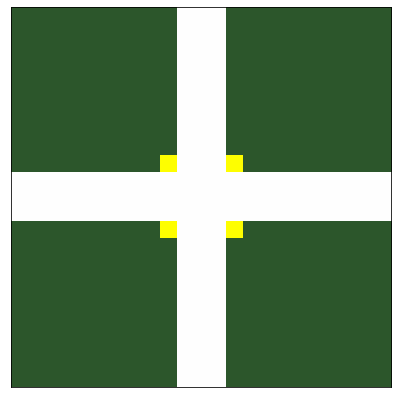

In [8]:
cmap = matplotlib.cm.get_cmap('viridis', 5)
cmap = cmap(np.linspace(0, 1, 5))

cmap[0] = np.array([255/256, 255/256, 255/256, 1]) # Calle | Blanco (255,255,255)
cmap[1] = np.array([45/256, 87/256, 44/256, 1]) # Jardin | Verde oscuro (45,87,44)
cmap[2] = np.array([255/256, 0/256, 0/256, 1]) # Semaforo | Rojo (255,0,0)
cmap[3] = np.array([0/256, 255/256, 0/256, 1]) # Semaforo | Verde (0,255,0)
cmap[4] = np.array([255/256, 255/256, 0/256, 1]) # Semaforo | Amarillo (255,255,0)


new_cmap = matplotlib.colors.ListedColormap(cmap)
fig, axs = plt.subplots(figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap=new_cmap)

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    
anim = animation.FuncAnimation(fig, animate, frames=200)

In [9]:
anim